In [1]:
import sys

In [2]:
sys.version

'3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]'

In [124]:
import tensorflow as tf
import pandas as pd
from pandas_datareader import data as wb
import numpy as np 
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [125]:
PG = wb.DataReader('PG', data_source='yahoo', start='2015-1-1', )


In [126]:
simple_return = (PG['Adj Close']/ PG['Adj Close'].shift(1))-1

In [131]:
#converting data into array to split into batches to feed the RNN model
a=simple_return.dropna()
sr = np.array(a)

num_periods = 20
f_horizon = 1

x_data = sr[:(len(sr)-(len(sr) % num_periods))]
x_batches = x_data.reshape(-1, 100, 1)

y_data = sr[:(len(sr)-(len(sr) % num_periods))+ f_horizon]
y_batches = x_data.reshape(-1, 100, 1)

print (len(x_batches))
print (x_batches.shape)
print (x_batches[0:2])

print (y_batches[0:1])
print (y_batches.shape)

11
(11, 100, 1)
[[[-0.00475453]
  [-0.00455475]
  [ 0.00524544]
  [ 0.01143529]
  [-0.00933021]
  [-0.00365658]
  [ 0.00422606]
  [-0.00343297]
  [-0.00144493]
  [ 0.01546882]
  [-0.00065735]
  [ 0.00202751]
  [ 0.00980929]
  [-0.01680858]
  [-0.00555063]
  [-0.03449435]
  [-0.01549332]
  [ 0.00610708]
  [-0.01610841]
  [ 0.00984715]
  [ 0.00975082]
  [-0.00186159]
  [ 0.01060715]
  [-0.01257188]
  [-0.00654128]
  [ 0.00399741]
  [ 0.00292796]
  [ 0.004554  ]
  [-0.00151125]
  [-0.00477294]
  [ 0.00900702]
  [-0.01217261]
  [-0.00399011]
  [ 0.00612682]
  [ 0.00128847]
  [-0.00046772]
  [-0.00339349]
  [-0.00046994]
  [ 0.00328939]
  [-0.00292706]
  [-0.00951161]
  [ 0.00331939]
  [-0.02327797]
  [ 0.00520218]
  [-0.01865449]
  [-0.00183964]
  [ 0.00860072]
  [-0.00316737]
  [ 0.02114145]
  [-0.00849682]
  [ 0.01086307]
  [-0.00441787]
  [ 0.01631075]
  [ 0.00141636]
  [-0.01107722]
  [-0.01084362]
  [-0.01036028]
  [ 0.00194759]
  [ 0.00498132]
  [-0.00942951]
  [ 0.00463749]
  [ 0.00

In [132]:
train_size = int(len(simple_return)*0.8)

In [133]:
train, test = simple_return[0:train_size], simple_return[train_size:len(simple_return)]

In [134]:
def test_data(series, forecast, num_periods):
    test_x_setup = sr[-(num_periods+forecast):]
    testx = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testy = sr[-(num_periods):].reshape(-1, 20, 1)
    return testx, testy
x_test, y_test = test_data(sr, f_horizon, num_periods )
print (x_test.shape)
print (x_test)
    

(1, 20, 1)
[[[-0.00927331]
  [ 0.00353393]
  [-0.00789951]
  [ 0.01698009]
  [ 0.00094329]
  [-0.00480635]
  [ 0.01041665]
  [ 0.01321466]
  [-0.00610493]
  [-0.00111675]
  [-0.00894437]
  [ 0.00329039]
  [ 0.00037482]
  [-0.00065567]
  [-0.02090171]
  [-0.00258469]
  [ 0.01094154]
  [-0.02297539]
  [ 0.00864833]
  [ 0.00847782]]]


In [135]:
tf.reset_default_graph()
#Setting Deep learning parameters
num_periods = 20
inputs = 1
hidden = 100
output = 1

# Create the placeholders
x = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)#create rnn object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, x, dtype=tf.float32)

learning_rate = .001

#change form to tensor, specify dense layer
stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

#minizming cost ducntion and using gradient descent optimizer
loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train. AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [106]:
#iterations for fowards and back propagation
epochs = 1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={x: x_batches, y: y_batches})
        if ep % 100 ==0:
            mse = loss.eval(feed_dict={x: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={x: x_test})
    print(y_pred)

0 	MSE: 0.04335587
100 	MSE: 0.0005523256
200 	MSE: 2.2995235e-05
300 	MSE: 0.00034265695
400 	MSE: 6.0550883e-06
500 	MSE: 6.1627275e-06
600 	MSE: 3.1832435e-06
700 	MSE: 3.7091695e-06
800 	MSE: 2.0548762e-06
900 	MSE: 4.6461373e-06
[[[-0.00930846]
  [ 0.00352257]
  [-0.00781898]
  [ 0.01700353]
  [ 0.00090882]
  [-0.00477594]
  [ 0.01045215]
  [ 0.01320195]
  [-0.00603959]
  [-0.00117529]
  [-0.00892726]
  [ 0.00329921]
  [ 0.00036578]
  [-0.00064162]
  [-0.02088861]
  [-0.00262917]
  [ 0.01097582]
  [-0.02302557]
  [ 0.00858461]
  [ 0.00847217]]]


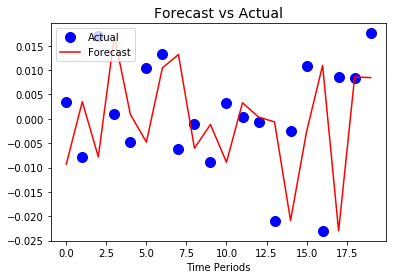

In [139]:
plt.title('Forecast vs Actual', fontsize=14)
plt.plot(pd.Series(np.ravel(y_test)), 'bo', markersize=10, label ='Actual')
plt.plot(pd.Series(np.ravel(y_pred)),'r', markersize=10, label='Forecast')
plt.legend(loc='upper left')
plt.xlabel('Time Periods')

plt.show()